# Project Milestone - Student Dropout Risk Predictor
## Random Forest Classifier for Option C: Web App for a Machine Learning Model

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
from sklearn.ensemble import RandomForestClassifier  # model type I'm training
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.metrics import f1_score

print("Libraries Loaded")

Libraries Loaded


## Import and Clean Data

Before anything happens, make sure data is in good shape for training.

**Note:** Unlike other datasets I've looked at, this one uses `;` instead of `,`. GPT 5.1 was used to assist in making sure data was parsed properly, as I suspect there may be other issues reading the data that I'm not immediately familiar with.

In [2]:
df = pd.read_csv(
    "./final-project-data.csv",
    sep=";",
    na_values=["", " "]
)
df.columns = [
    column.replace("\ufeff", "").strip().strip('"') for column in df.columns
]

# Dtypes
print('-------------------------')
print('Data Types')
print('-------------------------')
display(df.dtypes)
print()

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
print('-------------------------')
print('Missing Values (top 5):')
print('-------------------------')
display(missing.head(5))
print()

# Duplicates
print('-------------------------')
print('Duplicate rows:', df.duplicated().sum())
print('-------------------------')
if not df[df.duplicated(keep=False)].empty:
    display(df[df.duplicated(keep=False)])
print()


# Sample
print('-------------------------')
print('Data Sample')
print('-------------------------')
display(df.head())

-------------------------
Data Types
-------------------------


Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        


-------------------------
Missing Values (top 5):
-------------------------


Marital status                            0
Age at enrollment                         0
Curricular units 1st sem (credited)       0
Curricular units 1st sem (enrolled)       0
Curricular units 1st sem (evaluations)    0
dtype: int64


-------------------------
Duplicate rows: 0
-------------------------

-------------------------
Data Sample
-------------------------


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Function Definitions

This isn't a homework assignment, so I'm organizing things so that it makes sense to me.

**Note:** These will likely be moved into their own file for web app development. GPT 5.1 was used to help resolve issues with code syntax, and some language differences between python and javascript (I write lots of JS, and less python)

In [3]:
# Split the full DataFrame into feature columns (X) and the target label (y).
def split_features_target(
    dataframe: pd.DataFrame, target_column: str = "Target" # Target is the column that has "graduate", and "dropout" data
) -> Tuple[pd.DataFrame, pd.Series]:

    # shouldn't matter since the data won't be changing, but better to be safe
    if target_column not in dataframe.columns:
        raise KeyError(f"Target column '{target_column}' missing from dataset")

    features = dataframe.drop(columns=target_column).copy()
    labels = dataframe[target_column].astype("category")
    return features, labels


# Turn any string / categorical columns into integer codes so the model can use them.
def encode_categorical_features(features: pd.DataFrame) -> pd.DataFrame:

    # I don't know how it works here, but in JS, make a copy.... it'll save headaches later
    encoded = features.copy()
    categorical_columns = encoded.select_dtypes(include=["object", "category"]).columns

    for column in categorical_columns:
        encoded[column], _ = pd.factorize(encoded[column], sort=True)

    return encoded


# Create a reasonably strong random forest model for baseline results.
# Seed 42 because what else is it going to be 67?
def build_random_forest(random_state: int = 42) -> RandomForestClassifier:

    # GPT 5.1 used to help find areas where training could be imporved
    # "balanced_subsample" - Tells the model to automatically reweight classes based on how frequent they are in each bootstrap sample.

    return RandomForestClassifier(
        n_estimators=200,
        random_state=random_state,
        class_weight="balanced_subsample",
    )


# Evaluate how well the trained model predicts the target on held-out test data.
def evaluate_model(
    model: RandomForestClassifier,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
) -> None:
    """Plot train vs test performance and print a text classification report for test data."""

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Class ordering based on the target's categories
    class_names = y_test.cat.categories

    # Classification reports as dicts so we can pull out per-class metrics
    train_report = classification_report(
        y_train,
        train_pred,
        labels=class_names,
        output_dict=True,
        zero_division=0,
    )
    test_report = classification_report(
        y_test,
        test_pred,
        labels=class_names,
        output_dict=True,
        zero_division=0,
    )

    # Extract per-class F1 scores in a consistent order
    train_f1 = [train_report[str(label)]["f1-score"] for label in class_names]
    test_f1 = [test_report[str(label)]["f1-score"] for label in class_names]

    # Overall accuracies for the title
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    # Line plot: classes on x-axis, F1 score on y-axis; one line for train, one for test
    plt.figure(figsize=(8, 5))
    x_positions = range(len(class_names))

    plt.plot(x_positions, train_f1, marker="o", label=f"Train F1")
    plt.plot(x_positions, test_f1, marker="o", label=f"Test F1")

    plt.xticks(x_positions, class_names)
    plt.ylim(0, 1)
    plt.xlabel("Class")
    plt.ylabel("F1 score")
    plt.title(
        f"Train vs Test F1 by Class (train acc = {train_acc:.3f}, test acc = {test_acc:.3f})"
    )
    plt.legend()
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()

    # Still print the detailed classification report for the test set
    print("Test set classification report:\n")
    print(
        classification_report(
            y_test,
            test_pred,
            labels=class_names,
            zero_division=0,
        )
    )

## Where The Magic Gets Going

In [4]:
# Feature and target separation
features, labels = split_features_target(df)

# Feature Encoding
encoded_features = encode_categorical_features(features)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(
    encoded_features,
    labels,
    test_size=0.2, # 20% of the data is reserved for testing, 80% for training
    random_state=42, # Still wouldn't choose a different seed
    stratify=labels, # keeps proportions roughly the same in both train and test sets.
)

# Build, train, and evaluate model
model = build_random_forest()
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Note:** I don't know what that chart above is. It just shows up automatically ¯\\_(ツ)_/¯

## Training visualization

Instead of using the default settings, I'm going to do what was reccomended by gpt5.1:

- Split the training data again into a **smaller training set** and a **validation set**.
- Try a few combinations of random forest settings (depth, leaf size, class weights).
- Use **macro F1** on the validation set as the score, so each class (Dropout / Enrolled / Graduate) matters equally.
- Pick the best combo, retrain that model on the full training data, and compare it to the baseline.

In [5]:
# Split the original training set into a smaller train and a validation set
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,  # 25% of the original train becomes validation
    random_state=42,
    stratify=y_train,
)

param_grid = {
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "class_weight": ["balanced_subsample", "balanced"],
}

results = []

for max_depth, min_samples_leaf, class_weight in product(
    param_grid["max_depth"],
    param_grid["min_samples_leaf"],
    param_grid["class_weight"],
):
    candidate = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
    )
    candidate.fit(X_train_small, y_train_small)

    y_val_pred = candidate.predict(X_val)

    # Macro F1: treats each class equally (Dropout / Enrolled / Graduate)
    macro_f1 = f1_score(y_val, y_val_pred, average="macro")

    results.append(
        {
            "max_depth": max_depth,
            "min_samples_leaf": min_samples_leaf,
            "class_weight": class_weight,
            "macro_f1": macro_f1,
        }
    )

# Sort by macro F1 descending and show the top few
results_sorted = sorted(results, key=lambda r: r["macro_f1"], reverse=True)

print("Top 5 hyperparameter combinations by validation macro F1:\n")
for row in results_sorted[:5]:
    print(row)

best_params = results_sorted[0]
print("\nBest params:", best_params)

Top 5 hyperparameter combinations by validation macro F1:

{'max_depth': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced_subsample', 'macro_f1': 0.7085997411240106}
{'max_depth': 20, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample', 'macro_f1': 0.7071892530752263}
{'max_depth': None, 'min_samples_leaf': 5, 'class_weight': 'balanced_subsample', 'macro_f1': 0.7070060179144949}
{'max_depth': 10, 'min_samples_leaf': 5, 'class_weight': 'balanced', 'macro_f1': 0.7064793238592202}
{'max_depth': None, 'min_samples_leaf': 10, 'class_weight': 'balanced', 'macro_f1': 0.7059159070336422}

Best params: {'max_depth': 10, 'min_samples_leaf': 10, 'class_weight': 'balanced_subsample', 'macro_f1': 0.7085997411240106}



Baseline random forest (from earlier) vs tuned model:
- Baseline: 200 trees, max_depth=None, min_samples_leaf=1, class_weight='balanced_subsample'
- Tuned:   200 trees, max_depth=10, min_samples_leaf=10, class_weight=balanced_subsample
Test set classification report:

              precision    recall  f1-score   support

     Dropout       0.83      0.68      0.75       284
    Enrolled       0.44      0.61      0.51       159
    Graduate       0.85      0.83      0.84       442

    accuracy                           0.74       885
   macro avg       0.71      0.71      0.70       885
weighted avg       0.77      0.74      0.75       885



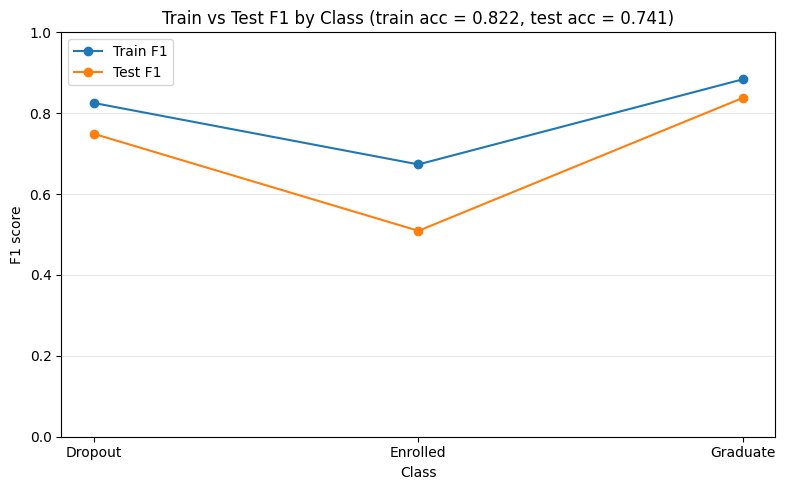

In [6]:
# Train a "best" model using the chosen hyperparameters and re-evaluate
best_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    class_weight=best_params["class_weight"],
)

best_model.fit(X_train, y_train)

print("\nBaseline random forest (from earlier) vs tuned model:")
print("- Baseline: 200 trees, max_depth=None, min_samples_leaf=1, class_weight='balanced_subsample'")
print("- Tuned:   200 trees, max_depth={max_depth}, min_samples_leaf={min_leaf}, class_weight={cw}".format(
    max_depth=best_params["max_depth"],
    min_leaf=best_params["min_samples_leaf"],
    cw=best_params["class_weight"],
))

# Reuse the same evaluation helper to compare train vs test performance
evaluate_model(best_model, X_train, y_train, X_test, y_test)